1. Teacher forcing
2. Truncated Backpropagation
2. Hidden state 추출하기
3. Sequence embedding

In [300]:
#라이브러리
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
#reproducibility
torch.manual_seed(0)

In [301]:
!pip3 install tsne-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


data: https://blockchain.info/ko/charts/market-price?timespan=60days

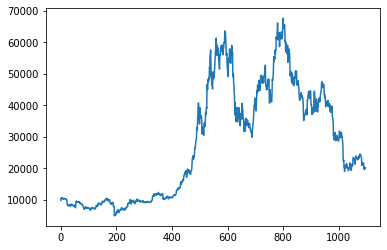

In [304]:
series = pd.read_csv('/content/drive/MyDrive/market-price.csv', header=0, index_col=0, squeeze=True) #이번시간은 여러 sample을 얻기 위해 가장 긴 term의 csv 받기
data = series[0:2000].tolist()
plt.plot(data)

In [564]:
# 하이퍼파라미터 설정
seq_length = 50
stride = 50
data_dim = 1 # 데이터는 1차원
hidden_dim = 64 # 임의 정의
output_dim = 1 # 종가는 1차원
learning_rate = 0.001
epoch = 250
teacher_forcing = False

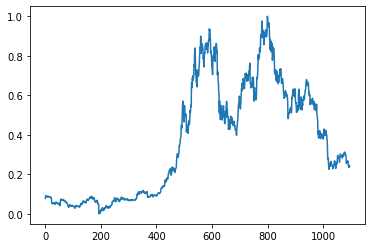

In [565]:
#train/test split 이전에 scaling 
minmax_scaler = MinMaxScaler()
data = minmax_scaler.fit_transform(np.array(data).reshape(-1,1))
plt.plot(data)

In [566]:
#하나의 시계열 데이터로 여러 샘플 얻기
#-sample 사이 state 연결은 되지 않지만, 
#truncated backpropagation through time을 간접적으로 구현
#RNN 의 hidden state representation을 sequence embedding하기 위한 sample 확보

def build_dataset(time_series, seq_length, stride):
  data = []
  for i in range(int((len(time_series)-seq_length)/stride)):
    data.append(time_series[i*stride:i*stride+seq_length,:])
  return data


In [567]:
#데이터 전처리, 텐서화
dataset = build_dataset(data,seq_length,stride)
dataset = torch.FloatTensor(dataset)
dataset.shape

torch.Size([20, 50, 1])

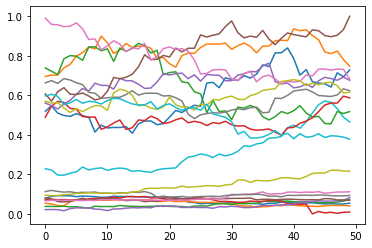

In [568]:
#생성된 시계열 샘플 시각화
for i in range(len(dataset)):
  plt.plot(dataset[i])
plt.show()


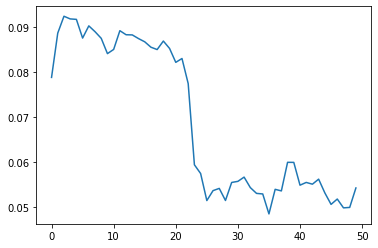

In [569]:
 plt.plot(dataset[0])

In [570]:
#얻어진 batch sample 각각에 대하여 train/test split이 가능
train_size = int(seq_length * 0.9) # 데이터의 90%를 train set으로 이용

train_set = dataset[:,0:train_size] # train set
test_set = dataset[:,train_size - seq_length:] # test set
batch_size = train_set.shape[0]
train_set.shape

torch.Size([20, 45, 1])

In [571]:
# RNN 모델(LSTM) 만들어 두기
class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.GRU(input_dim, hidden_dim, num_layers = layers, batch_first=True) # RNN 모델로 GRU 이용, LSTM은 h,c state를 갖고 있는 반면, GRU는 h state만 갖고 있으므로 분석이 더 간단
    self.fc = torch.nn.Linear(hidden_dim, output_dim, bias = True) # FC Layer

  def forward(self, x, h):
    x, _status = self.rnn(x, h) # RNN 모델
    x = self.fc(x[:, -1]) # FC Layer
    return x, _status

In [572]:
# 6. RNN 모델(LSTM) 이용하기
net = Net(data_dim, hidden_dim, output_dim, 1) # input_dim, hidden_dim, output_dim, 레이어 수를 설정하여 모델 이용

# 7. Loss와 Optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [573]:
length = train_set.shape[1]
#h0 = torch.randn(1,batch_size,hidden_dim)
h0 = torch.zeros(1,batch_size,hidden_dim)
for i in range(epoch):
  loss_ = 0
  for j in range(length-1):
    if j==0: 
      x = train_set[:,1].unsqueeze(1) #batch/(sequence)/dimension
      h = h0
    
    output, h = net(x,h)

    if teacher_forcing==True:
      x = train_set[:,j].unsqueeze(1) # use train data as next input
    else:
      x = output.unsqueeze(1) #use previous output as next input

    y = train_set[:,j+1].unsqueeze(1)

    loss = criterion(output, y) # 예측값과 실제값을 통한 loss 구하기
    loss_ += loss
  loss_ /= length -1

  optimizer.zero_grad()
  loss_.backward()
  optimizer.step()

  print(i, loss_.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([20, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 0.22342348098754883
1 0.20498694479465485
2 0.18809260427951813
3 0.1727014183998108
4 0.15875202417373657
5 0.1461811065673828
6 0.1349344700574875
7 0.12497370690107346
8 0.11628170311450958
9 0.1088632270693779
10 0.10274147987365723
11 0.09795098751783371
12 0.09452591091394424
13 0.09247958660125732
14 0.09176986664533615
15 0.09224498271942139
16 0.09358292073011398
17 0.09528804570436478
18 0.09682223945856094
19 0.0977959930896759
20 0.0980624407529831
21 0.09768449515104294
22 0.096844382584095
23 0.09575774520635605
24 0.09461701661348343
25 0.0935644805431366
26 0.0926869586110115
27 0.09202254563570023
28 0.09157276153564453
29 0.09131496399641037
30 0.09121345728635788
31 0.09122755378484726
32 0.09131741523742676
33 0.09144746512174606
34 0.09158837795257568
35 0.09171757847070694
36 0.0918194130063057
37 0.09188436716794968
38 0.09190847724676132
39 0.09189233183860779
40 0.09183990955352783
41 0.09175780415534973
42 0.09165430068969727
43 0.09153823554515839
44 0.0914

In [582]:
#학습한 sequence의 최종 hidden state 얻기
h.shape
X = h.squeeze().detach().numpy()
X.shape

(20, 64)

# PCA

In [575]:
#hidden dimension에 PCA 적용해서 2차원으로 축소
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
result = pca.fit(X.T)
X_PCA = result.components_.T


In [583]:
X_PCA.shape

(20, 2)

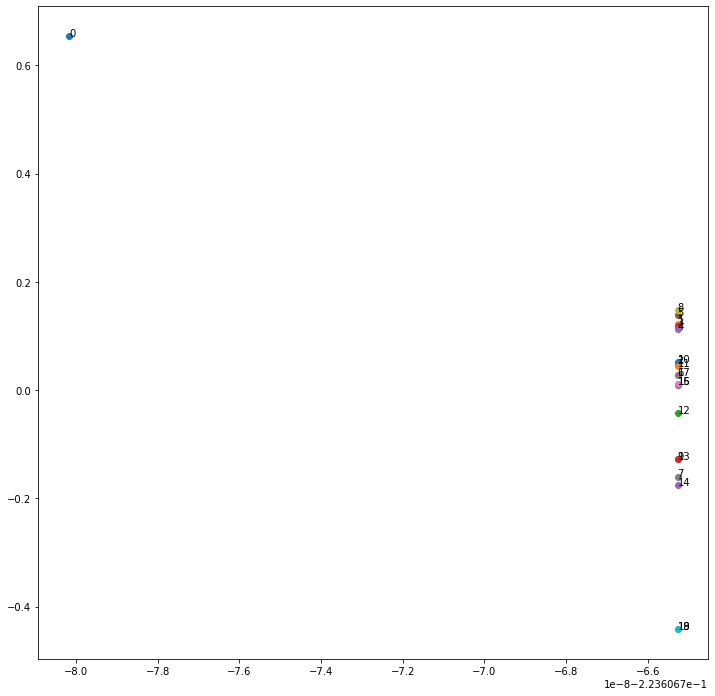

In [584]:
#sequence embedding을 통해 추가 분석(클러스터링/분류) 가능
plt.figure(figsize=(12,12))
for i in range(len(X_PCA)):
  #print(result.components_.T[i,0],result.components_.T[i,1])
  plt.scatter(X_PCA[i,0],X_PCA[i,1])
  plt.text(X_PCA[i,0],X_PCA[i,1], i, fontsize=10)


# T-SNE

In [586]:
from tsne_torch import TorchTSNE as TSNE
X_TSNE = TSNE(n_components=2, perplexity=6, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

using cpu
initializing...
computing p-values...
100%|██████████| 20/20 [00:00<00:00, 62.59it/s]
fitting...
error: 0.239: 100%|██████████| 1000/1000 [00:06<00:00, 162.13it/s]


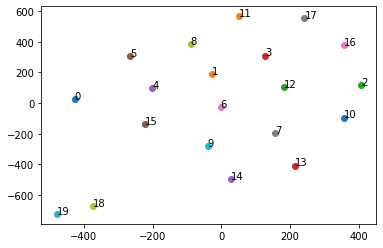

In [587]:
for i in range(len(X)):
  plt.scatter(X_TSNE[i,0],X_TSNE[i,1])
  plt.text(X_TSNE[i,0],X_TSNE[i,1], i, fontsize=10)

#PCA/T-SNE를 거친 hidden representation으로부터 Sequence Clustering

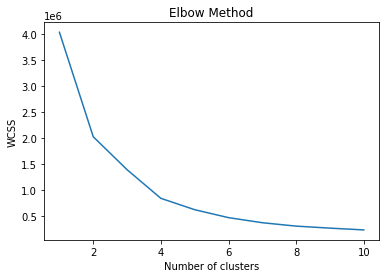

In [588]:
from sklearn.cluster import KMeans

#X_ = X_PCA
X_ = X_TSNE
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

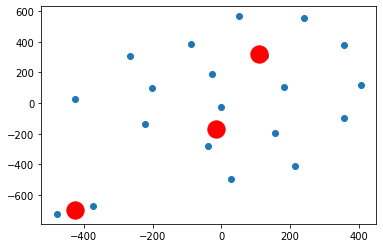

In [589]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_) # cluster labels
plt.scatter(X_[:,0], X_[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [590]:
X_.shape

(20, 2)

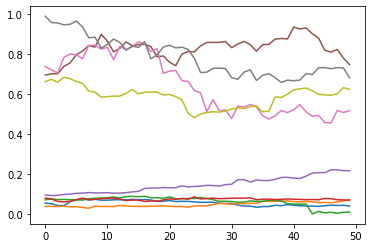

0


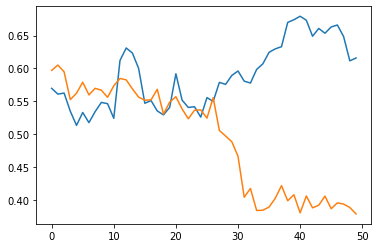

1


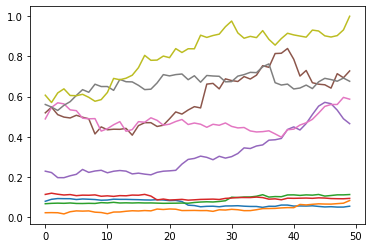

2


In [591]:
#sequence embedding point를 다시 sequence로 확인
for j in range(max(pred_y)+1):
  for i in range(len(dataset)):
    if pred_y[i]==j:
      plt.plot(dataset[i])
  plt.show()
  print(j)

In [563]:
pred_y

array([0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 1,
       2, 0, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1],
      dtype=int32)

# **Truncated Backpropagation Through Time**

crd:https://discuss.pytorch.org/t/implementing-truncated-backpropagation-through-time/15500/2


In [238]:

class TBPTT():
    def __init__(self, one_step_module, loss_module, k1, k2, optimizer):
        self.one_step_module = one_step_module
        self.loss_module = loss_module
        self.k1 = k1
        self.k2 = k2
        self.retain_graph = k1 < k2
        # You can also remove all the optimizer code here, and the
        # train function will just accumulate all the gradients in
        # one_step_module parameters
        self.optimizer = optimizer

    def train(self, input_sequence, init_state):
        states = [(None, init_state)]
        for j, (inp, target) in enumerate(input_sequence):

            state = states[-1][1].detach()
            state.requires_grad=True
            output, new_state = self.one_step_module(inp, state)
            states.append((state, new_state))

            while len(states) > self.k2:
                # Delete stuff that is too old
                del states[0]

            if (j+1)%self.k1 == 0:
                loss = self.loss_module(output, target)

                optimizer.zero_grad()
                # backprop last module (keep graph only if they ever overlap)
                start = time.time()
                loss.backward(retain_graph=self.retain_graph)
                for i in range(self.k2-1):
                    # if we get all the way back to the "init_state", stop
                    if states[-i-2][0] is None:
                        break
                    curr_grad = states[-i-1][0].grad
                    states[-i-2][1].backward(curr_grad, retain_graph=self.retain_graph)
                print("bw: {}".format(time.time()-start))
                optimizer.step()



seq_len = 20
layer_size = 50

idx = 0

class MyMod(nn.Module):
    def __init__(self):
        super(MyMod, self).__init__()
        self.lin = nn.Linear(2*layer_size, 2*layer_size)

    def forward(self, inp, state):
        global idx
        full_out = self.lin(torch.cat([inp, state], 1))
        # out, new_state = full_out.chunk(2, dim=1)
        out = full_out.narrow(1, 0, layer_size)
        new_state = full_out.narrow(1, layer_size, layer_size)
        def get_pr(idx_val):
            def pr(*args):
                print("doing backward {}".format(idx_val))
            return pr
        new_state.register_hook(get_pr(idx))
        out.register_hook(get_pr(idx))
        print("doing fw {}".format(idx))
        idx += 1
        return out, new_state


one_step_module = MyMod()
loss_module = nn.MSELoss()
input_sequence = [(torch.rand(200, layer_size), torch.rand(200, layer_size))] * seq_len

optimizer = torch.optim.SGD(one_step_module.parameters(), lr=1e-3)

runner = TBPTT(one_step_module, loss_module, 5, 7, optimizer)

runner.train(input_sequence, torch.zeros(200, layer_size))
print("done")

doing fw 0
doing fw 1
doing fw 2
doing fw 3
doing fw 4
doing backward 4
doing backward 3
doing backward 2
doing backward 1
doing backward 0
bw: 0.012289047241210938
doing fw 5
doing fw 6
doing fw 7
doing fw 8
doing fw 9
doing backward 9
doing backward 8
doing backward 7
doing backward 6
doing backward 5
doing backward 4


RuntimeError: ignored